In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline


In [2]:
cd /Users/austinmcdonald/Desktop/test/cut/

/Users/austinmcdonald/Desktop/test/cut


In [3]:
DataSet = os.listdir()
DataSet = [x for x in DataSet if x != '.DS_Store']
DataSet

['Ba', 'Ca', 'Na']

In [4]:
DataPath = '/Users/austinmcdonald/Desktop/test/cut'

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [97]:
eCoeff = 0.01160
eOffset= 1917
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREAPOST=dict()
AREASS=dict()
CHIR= dict()
MEAND= dict()
MEANI=dict()
MEANE=dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    MASTERareaPost=[]
    MASTERmeanI=[]
    MASTERmeanE=[]

    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        for x in range(700,750):
            Images = np.array(Image.open(folder+'/'+files[x]))
            Images = eCoeffM*(Images - eOffsetM)
            #Mfit = np.zeros(len(xvs)) # kill this ?
            ImageFit = []
            for y in range(0,Shape):
                coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
                ffit  = poly.polyval(xvs, coefs)
                ImageFit.append(ffit)
            MeanFit+=np.array(ImageFit)
        MeanFit = MeanFit/50


        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            DataSub += Images


        data = DataSub

        threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 


        Images = None
        ImageB = None
        #data   = None
        Slices = None
        labeled= None
        num_objects=None

        ############################################################## 
        Xc=[]
        Yc=[]
        for qw in range(0,len(AllPairs)):
            XX = AllPairs[qw][0]
            YY = AllPairs[qw][1]
            if XX>10 and XX<210 and YY>10 and YY<210:
                Xc.append(XX)
                Yc.append(YY)
        #try:
            #Xc=[]
            #Yc=[]
            #for qw in range(0,len(AllPairs)):
                #XX = AllPairs[qw][0]
                #YY = AllPairs[qw][0]
                #if XX>10 and XX<210 and YY>10 and YY<210:
                    #Xc.append(XX)
                    #Yc.append(YY)
        #except ValueError:
            #break
            #Xc=0
            #Yc=0
            #AllPairs=0

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(AllPairs)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]*(25/56)
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
            vals =np.arange(0,len(aa))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit)

            meanI = np.mean(Sig[:Mnumb])
            sigmaI = np.std(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            sigmaE = np.std(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        #chiF = []
        #chiB = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        Offset =3
        for x in range(0,Par):
            TauH   = Tau3[x]
            Data = running_mean(Signal[x],4)
            DataLeft  = Data[:int(TauH)-Offset]
            DataRight = Data[int(TauH)+Offset:]
            sigma = np.std(Data)
            mean  = np.mean(Data)
            meanI  = np.mean(DataLeft)
            sigmaI = np.std(DataLeft)
            meanE  = np.mean(DataRight)
            sigmaE = np.std(DataRight)
            Inten  = Signal[x][:int(TauH)]
            Intensity  = np.sum(Inten)/len(Inten)#######  mean? wtf man
            chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
            chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
            val = np.arange(0,len(Data),1)
            fit=np.polyfit(val,Data,1)    
            chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
            ###dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
            #data.append([Signal[x],TauH,Intensity])
            #PairsMade.append(AllPairs[x])
            #chiF.append(chiHIGH)
            #chiB.append(chiLOW)
            #chiFIT.append(chiFit)
            ITEN.append(Intensity)
            chiRa.append((chiLOW+chiHIGH)/ chiFit)
            meanDif.append(meanI-meanE)
            ###Dtau.append(dtau)
            areaS.append(Signal[x])
            areaSS.append(Data)
            areaPre.append(DataLeft)
            areaPost.append(DataRight)
            MeanI.append(meanI)
            MeanE.append(meanE)

        MASTERTau.append(Tau3)
        MASTERItn.append(ITEN)
        MASTERarea.append(areaS)
        MASTERareaSS.append(areaSS)
        MASTERareaPre.append(areaPre)
        MASTERareaPost.append(areaPost)

        MASTERchiRa.append(chiRa)
        MASTERmeanD.append(meanDif)
        MASTERmeanI.append(MeanI)
        MASTERmeanE.append(MeanE)
        
    MEANI[z] = [item for sublist in MASTERmeanI for item in sublist] 
    MEANE[z] = [item for sublist in MASTERmeanE for item in sublist]
    LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    INTENSITY[z]= [item for sublist in MASTERItn for item in sublist]
    AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    AREASS[z]     = [item for sublist in MASTERareaSS for item in sublist]

    CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]

    #AreaFull[z]  = [item for sublist in AreaHH for item in sublist]
    #AreaCUT[z]   = [item for sublist in SpotAreaHH for item in sublist]
    #PairsM[z]    = [item for sublist in PairsMade for item in sublist]
    #PairsA[z]    = [item for sublist in PPairs for item in sublist]
    #AreaCUT2[z]  = [item for sublist in SpotAreaHH2 for item in sublist]
    #PairsM2[z]   = [item for sublist in PairsMade2 for item in sublist]
    #Bleached[z]  = Bleach

Finding all areas in dataset 2
Finding all areas in folder 21
On file 750 of 750


In [98]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' pairs = ',len(LIFETIME[x]))

Ba  pairs =  2072
Ca  pairs =  1555
Na  pairs =  1922


In [99]:
SAVE = '/Users/austinmcdonald/Desktop/test-images/spots/'

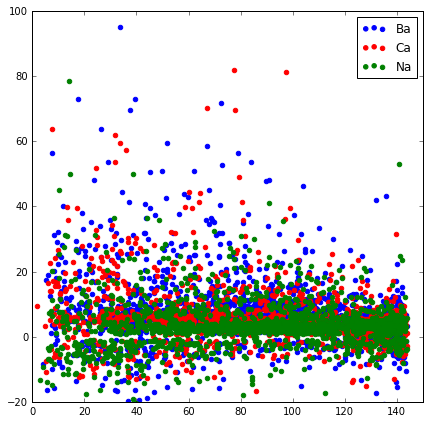

In [100]:
plt.figure(figsize=(7,7))
bright=dict()
life=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(LIFETIME[x])):
        if MEANE[x][z]<0:
            Correct = abs(MEANE[x][z])
        else:
            Correct = -abs(MEANE[x][z])
        LT.append(LIFETIME[x][z])
        IT.append(INTENSITY[x][z]+Correct)
    life[x]=LT# = [item for sublist in LT for item in sublist]
    bright[x]=IT# = [item for sublist in IT for item in sublist]

    
plt.scatter(life[0],bright[0],color='b',label=DataSet[0])
plt.scatter(life[1],bright[1],color='r',label=DataSet[1])
plt.scatter(life[2],bright[2],color='g',label=DataSet[2])
vars=np.arange(0,100,1)
plt.legend()
plt.xlim(0,150)
plt.ylim(-20,100)
#plt.savefig(SAVE+'RAWlifetime')

plt.show()

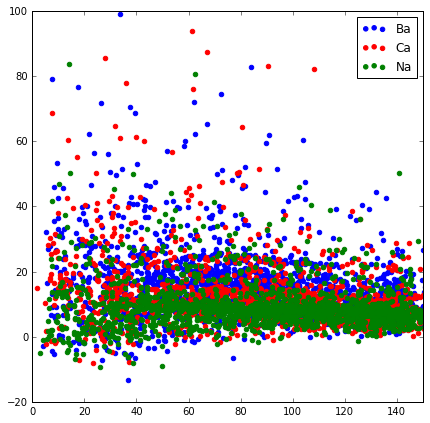

In [101]:
plt.figure(figsize=(7,7))
plt.scatter(LIFETIME[0],INTENSITY[0],color='b',label=DataSet[0])
plt.scatter(LIFETIME[1],INTENSITY[1],color='r',label=DataSet[1])
plt.scatter(LIFETIME[2],INTENSITY[2],color='g',label=DataSet[2])
#fitba=np.polyfit(LIFETIME[0],INTENSITY[0],1)
#fitca=np.polyfit(LIFETIME[1],INTENSITY[1],1)
#fitna=np.polyfit(LIFETIME[2],INTENSITY[2],1)
vars=np.arange(0,100,1)
#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
#plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,150)
plt.ylim(-20,100)
#plt.savefig(SAVE+'RAWlifetime')

plt.show()

In [102]:
itensity=dict()
lifetime=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(LIFETIME[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1 :#and MEANE[x][z]<20:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            LT.append(LIFETIME[x][z])
            IT.append(INTENSITY[x][z]+Correct)
    lifetime[x]=LT# = [item for sublist in LT for item in sublist]
    itensity[x]=IT# = [item for sublist in IT for item in sublist]
len(lifetime[0])

118

Ba tau =  693.6174 ms
Ca tau =  -1929.2775 ms
Na tau =  379.4159 ms


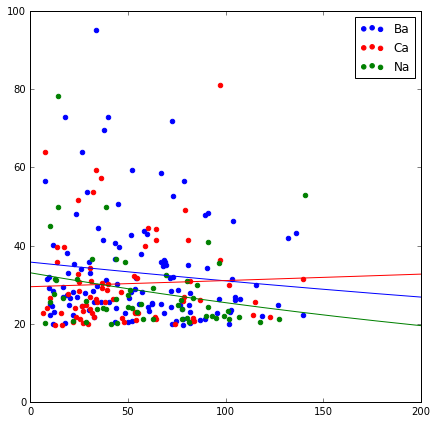

In [103]:
plt.figure(figsize=(7,7))

plt.scatter(lifetime[0],itensity[0],color='b',label=DataSet[0])
plt.scatter(lifetime[1],itensity[1],color='r',label=DataSet[1])
plt.scatter(lifetime[2],itensity[2],color='g',label=DataSet[2])
fitba,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[0],  itensity[0],  p0=(1, 0.1))
fitca,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[1],  itensity[1],  p0=(1, 0.1))
fitna,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[2],  itensity[2],  p0=(1, 0.1))
vars=np.arange(0,500,1)
plt.plot(vars,fitba[0]*np.exp(fitba[1]*vars),color='b')
plt.plot(vars,fitca[0]*np.exp(fitca[1]*vars),color='r')
plt.plot(vars,fitna[0]*np.exp(fitna[1]*vars),color='g')

#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,200)
plt.ylim(0,100)
print('Ba tau = ',"%.4f"%(-1/fitba[1]),"ms")
print('Ca tau = ',"%.4f"%(-1/fitca[1]),"ms")
print('Na tau = ',"%.4f"%(-1/fitna[1]),"ms")
#plt.savefig(SAVE+'CUTlifetime')

plt.show()

In [104]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' Passes Cuts = ',len(lifetime[x]))

Ba  Passes Cuts =  118
Ca  Passes Cuts =  73
Na  Passes Cuts =  55


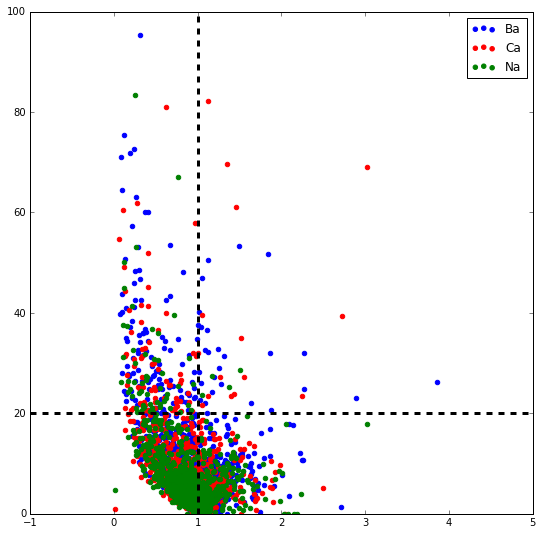

In [105]:
plt.figure(figsize=(9,9))
plt.scatter(CHIR[0],MEAND[0],color='b',label=DataSet[0])
plt.scatter(CHIR[1],MEAND[1],color='r',label=DataSet[1])
plt.scatter(CHIR[2],MEAND[2],color='g',label=DataSet[2])
plt.axhline(20,linewidth=3,linestyle='--',color='k')
plt.axvline(1,linewidth=3,linestyle='--',color='k')
plt.legend()
#plt.xlim(.3,2)
plt.ylim(0,100)
#plt.savefig(SAVE+'CUTspace')

plt.show()

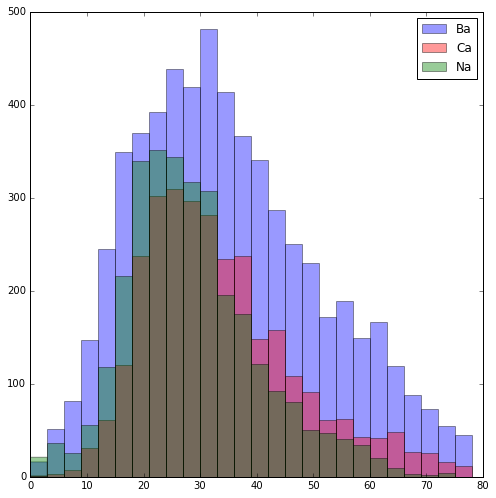

In [106]:
'''Hist of the areas before the bleach'''
AreaPass=dict()
for x in range(0,len(DataSet)):
    AP=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            AP.append(AREAPRE[x][z])
            #AP.append(INTENSITY[x][z])
    AreaPass[x] = [item for sublist in AP for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num))
plt.hist(AreaPass[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num))
plt.hist(AreaPass[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre')
plt.show()

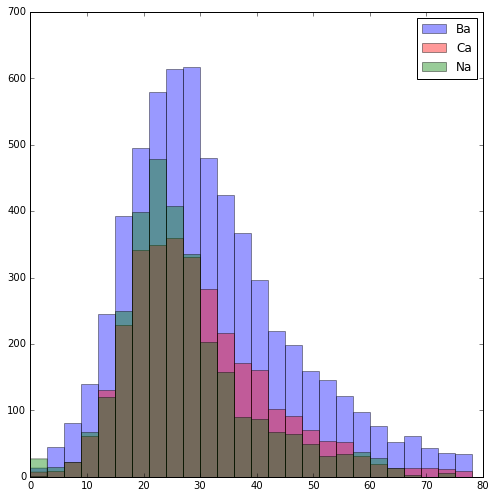

In [107]:
'''Hist of areas before bleach plus the mean of the base line'''

AreaPass1=dict()
for x in range(0,len(DataSet)):
    AP=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            ass=np.array(AREAPRE[x][z])+Correct
            AP.append(ass)
            #AP.append(AREAPRE[x][z])
            #AP.append(INTENSITY[x][z])
    AreaPass1[x] = [item for sublist in AP for item in sublist]
    
plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass1[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num))
plt.hist(AreaPass1[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num))
plt.hist(AreaPass1[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-meancor')
plt.show()
AreaPass=None 

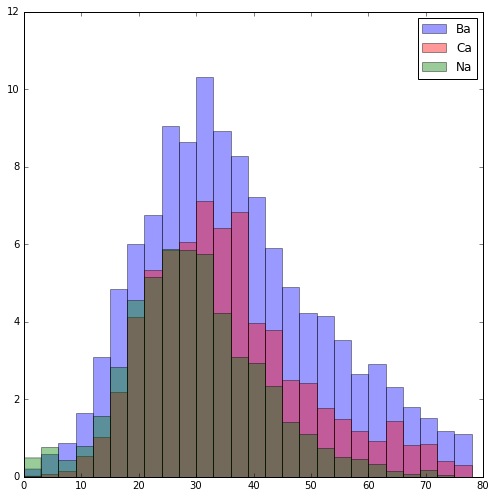

In [108]:
'''Hist of the areas before the bleach weighted by lifetime'''
AreaPass2=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            W = np.ones(len(AREAPRE[x][z]))/len(AREAPRE[x][z])
            AP.append(AREAPRE[x][z])
            WW.append(W)
            #AP.append(INTENSITY[x][z])
    AreaPass2[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass2[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass2[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass2[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-lifeWgh')
plt.show()

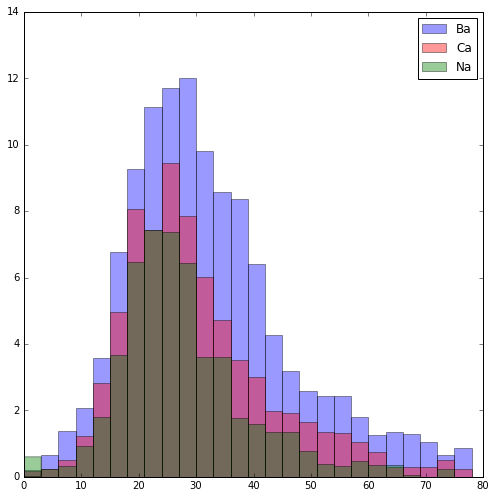

In [109]:
'''Hist of the areas before the plus the mean and weighted by lifetime'''
AreaPass3=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREAPRE[x][z]))/len(AREAPRE[x][z])
            WW.append(W)
            asss=np.array(AREAPRE[x][z])+Correct
            AP.append(asss)
    AreaPass3[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass3[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass3[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass3[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-meancor-lifeWgh')
plt.show()

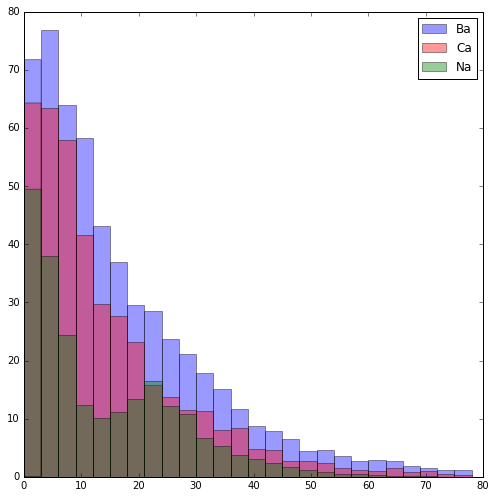

In [110]:
'''Hist of the areas  weighted by lifetime'''
AreaPass4=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            W = np.ones(len(AREASS[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREASS[x][z])
            AP.append(assss)
    AreaPass4[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass4[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass4[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass4[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapreRAW-lifeWgh')
plt.show()

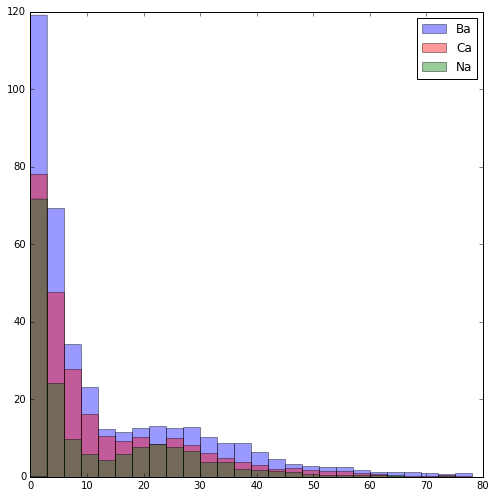

In [111]:
'''Hist of the areas  weighted by lifetime and mean corrected'''
AreaPass4=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREASS[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREASS[x][z])+Correct
            AP.append(assss)
    AreaPass4[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass4[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass4[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass4[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapreRAW-meancor-lifeWgh')
plt.show()

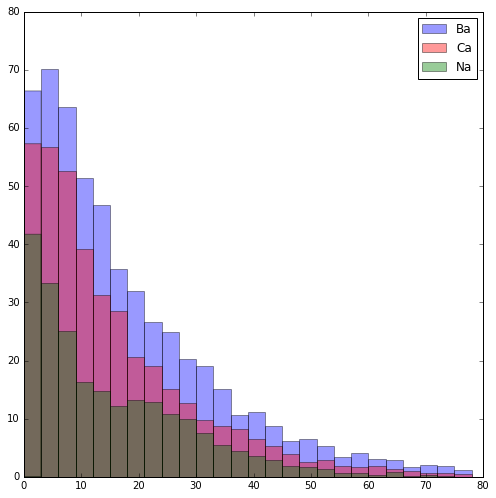

In [112]:
'''Hist of the FULLareas  weighted by lifetime'''
AreaPass7=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:

            W = np.ones(len(AREA[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREA[x][z])
            AP.append(assss)
    AreaPass7[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass7[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass7[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass7[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

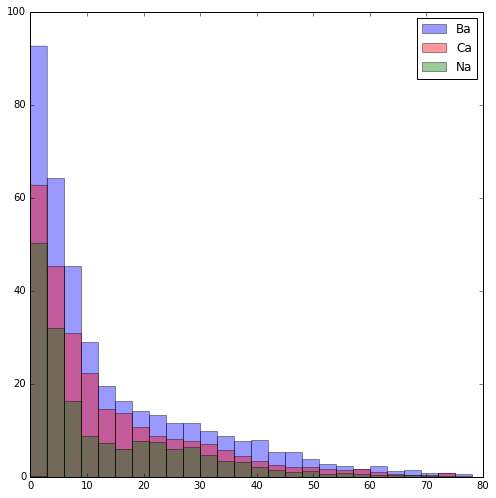

In [113]:
'''Hist of the FULLareas  weighted by lifetime and mean corrected'''
AreaPass8=dict()
Wei=dict()
Col=['b','r','g']
for x in range(0,len(DataSet)):
    AP=[]
    WW=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>20 and CHIR[x][z]<1:
            if MEANE[x][z]<0:
                Correct = abs(MEANE[x][z])
            else:
                Correct = -abs(MEANE[x][z])
            W = np.ones(len(AREA[x][z]))/len(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            WW.append(W)
            assss=np.array(AREA[x][z])+Correct
            AP.append(assss)
    AreaPass8[x] = [item for sublist in AP for item in sublist]
    Wei[x]=[item for sublist in WW for item in sublist]

plt.figure(figsize=(7,7))
num =3
plt.hist(AreaPass8[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(0,80,num),weights=Wei[0])
plt.hist(AreaPass8[1],label=DataSet[1],alpha=0.4,color='r',bins=np.arange(0,80,num),weights=Wei[1])
plt.hist(AreaPass8[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(0,80,num),weights=Wei[2])
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()